# Hybrid ARIMA - SVM Model

***

### Package Imports

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

***

### Loading and Processing the data

In [113]:
# Oil price data
oil_df = pd.read_csv('Full_crude_oil_data.csv', index_col = 'Date')
oil_df.drop({'Unnamed: 0'}, inplace = True, axis = 1)
oil_df.index = pd.to_datetime(oil_df.index)

# Sentiment data
sentiment_df = pd.read_csv('Tweet_Sentiment_Per_Day.csv', index_col = 'Date')
sentiment_df.drop({'Unnamed: 0'}, inplace = True, axis = 1)
sentiment_df.index = pd.to_datetime(sentiment_df.index)
sentiment_df = sentiment_df.sort_index()

***

<AxesSubplot:xlabel='Date'>

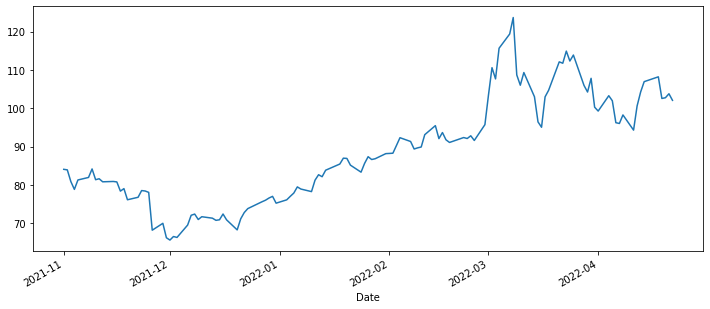

In [114]:
# Oil price graph
oil_df['Close'].plot(figsize=(12,5))

<AxesSubplot:>

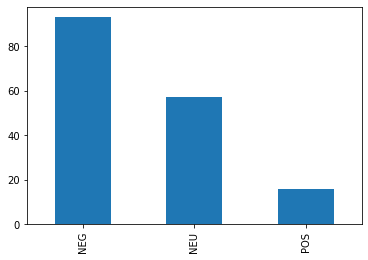

In [115]:
# Value counts for each sentiment
sentiment_freq = sentiment_df['Sentiment'].value_counts()
sentiment_freq.plot.bar()

In [116]:
# Get sentiment score from sentiment
def sentiment_score(Sentiment):
    if(Sentiment == 'POS'):
        return 100
    if(Sentiment == 'NEU'):
        return 80
    if(Sentiment == 'NEG'):
        return 60

# add a new column 'sentimentScore' to sentiment_df    
for i, r in sentiment_df.iterrows():
    sentiment_df.loc[i, ['sentimentScore']] = sentiment_score(r['Sentiment'])

sentiment_df    

,Sentiment,sentimentScore
Date,,
2021-10-31,NEG,60.0
2021-11-02,POS,100.0
2021-11-03,NEU,80.0
2021-11-04,NEG,60.0
2021-11-05,NEU,80.0
...,...,...
2022-04-19,NEG,60.0
2022-04-20,NEG,60.0
2022-04-21,NEG,60.0


<AxesSubplot:xlabel='Date'>

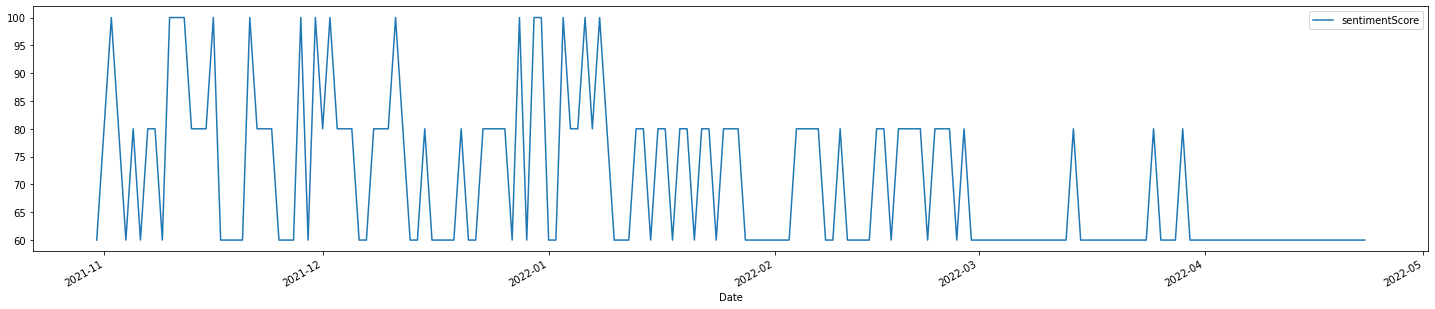

In [117]:
sentiment_df.plot(figsize = (25, 5))

In [118]:
# Merge oil_df adnd sentiment_df
merge_df = pd.merge(sentiment_df, oil_df, left_index = True, right_index = True)

# Drop unwanted columns
merge_df.drop({'Open', 'High', 'Low', 'Adj Close', 'Volume'}, inplace = True, axis = 1)
merge_df

,Sentiment,sentimentScore,Close
Date,,,
2021-11-02,POS,100.0,83.910004
2021-11-03,NEU,80.0,80.860001
2021-11-04,NEG,60.0,78.809998
2021-11-05,NEU,80.0,81.269997
2021-11-08,NEU,80.0,81.930000
...,...,...,...
2022-04-18,NEG,60.0,108.209999
2022-04-19,NEG,60.0,102.559998
2022-04-20,NEG,60.0,102.750000


In [119]:
merge_df['sentimentDiff'] = merge_df['sentimentScore'].diff()
merge_df['oilCloseDiff'] = merge_df['Close'].diff()
merge_df.fillna(0)

,Sentiment,sentimentScore,Close,sentimentDiff,oilCloseDiff
Date,,,,,
2021-11-02,POS,100.0,83.910004,0.0,0.000000
2021-11-03,NEU,80.0,80.860001,-20.0,-3.050003
2021-11-04,NEG,60.0,78.809998,-20.0,-2.050003
2021-11-05,NEU,80.0,81.269997,20.0,2.459999
2021-11-08,NEU,80.0,81.930000,0.0,0.660004
...,...,...,...,...,...
2022-04-18,NEG,60.0,108.209999,0.0,1.260002
2022-04-19,NEG,60.0,102.559998,0.0,-5.650002
2022-04-20,NEG,60.0,102.750000,0.0,0.190002


***
### ARIMA Model

In [126]:
# Train the model
train, test = train_test_split(merge_df[['sentimentScore', 'Close']], test_size = 0.2, shuffle = False)

model = ARIMA(train['Close'], order = (1, 0, 1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                   91
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -215.439
Date:                Sat, 14 May 2022   AIC                            438.878
Time:                        12:24:25   BIC                            448.922
Sample:                             0   HQIC                           442.930
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.5974      9.672      9.057      0.000      68.641     106.553
ar.L1          0.9674      0.027     36.108      0.000       0.915       1.020
ma.L1          0.1598      0.087      1.836      0.066      -0.011       0.330
sigma2         6.4457      0.644     10.010      0.000       5.184       7.708
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                43.44
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.22
Prob(H) (two-sided):                  0.23   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
train, test = train_test_split(merge_df[['sentimentScore', 'Close']], test_size=0.2, shuffle=False)

***

### Moving Average (i.e. Rolling mean)

<AxesSubplot:xlabel='Date'>

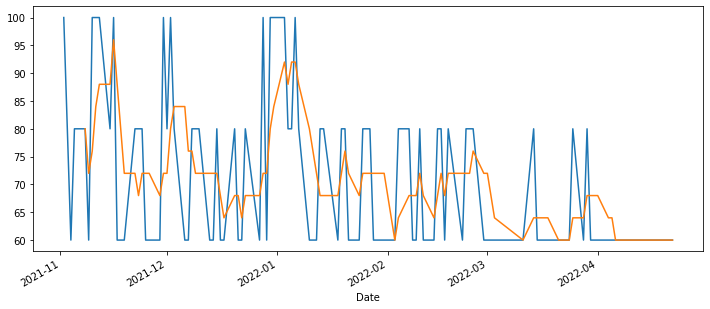

In [121]:
merge_df['sentimentScore'].plot()
merge_df['sentimentScore'].rolling(window = 5).mean().plot(figsize = (12, 5))

<AxesSubplot:xlabel='Date'>

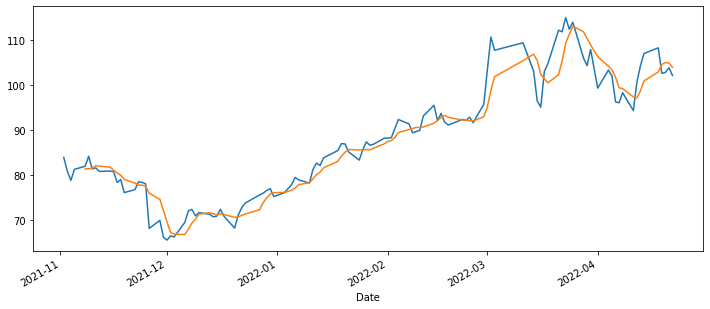

In [122]:
merge_df['Close'].plot()
merge_df['Close'].rolling(window = 5).mean().plot(figsize = (12, 5))

In [123]:
merge_df['MovingAverageOil'] = merge_df['Close'].rolling(window = 5).mean()
merge_df.fillna(0)

,Sentiment,sentimentScore,Close,sentimentDiff,oilCloseDiff,MovingAverageOil
Date,,,,,,
2021-11-02,POS,100.0,83.910004,0.0,0.000000,0.000000
2021-11-03,NEU,80.0,80.860001,-20.0,-3.050003,0.000000
2021-11-04,NEG,60.0,78.809998,-20.0,-2.050003,0.000000
2021-11-05,NEU,80.0,81.269997,20.0,2.459999,0.000000
2021-11-08,NEU,80.0,81.930000,0.0,0.660004,81.356000
...,...,...,...,...,...,...
2022-04-18,NEG,60.0,108.209999,0.0,1.260002,102.859999
2022-04-19,NEG,60.0,102.559998,0.0,-5.650002,104.513998
2022-04-20,NEG,60.0,102.750000,0.0,0.190002,104.943999
